In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
url = '/content/drive/MyDrive/SoftComputing/'

In [4]:
dataset_A = url + 'Dataset A.zip'
with ZipFile(dataset_A, 'r') as zip:
  zip.extractall()

In [5]:
PATH = '/content/'
data_labels = pd.read_csv(PATH + 'training-a.csv', usecols = ['filename', 'digit'])
print(data_labels.shape)
data_labels.head()

(19702, 2)


,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0


In [6]:
TRAIN_PATH = url + 'Train'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-a')

In [7]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [8]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(data_labels, TRAIN_PATH, train_transform)
test_data = Dataset(data_labels, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  19702


# **Base Parameters**

In [9]:
batch_size = 80
num_iters = 50000
input_dim = 28*28
num_hidden = 900
output_dim = 10

learning_rate = 0.05

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

203


In [10]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:198
Test dataloader:50


In [11]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [12]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=900, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=900, out_features=900, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=900, out_features=900, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=900, out_features=900, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=900, out_features=900, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=900, out_features=900, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=900, out_features=10, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [14]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Epoch:  3
Iteration: 500. Loss: 2.299156904220581. Accuracy: 10.48223350253807
Epoch:  4
Epoch:  5
Epoch:  6
Iteration: 1000. Loss: 2.297672748565674. Accuracy: 17.766497461928935
Epoch:  7
Epoch:  8
Iteration: 1500. Loss: 2.2894980907440186. Accuracy: 9.720812182741117
Epoch:  9
Epoch:  10
Epoch:  11
Iteration: 2000. Loss: 2.2174315452575684. Accuracy: 13.756345177664974
Epoch:  12
Epoch:  13
Iteration: 2500. Loss: 2.168926477432251. Accuracy: 15.609137055837563
Epoch:  14
Epoch:  15
Epoch:  16
Iteration: 3000. Loss: 2.1636240482330322. Accuracy: 19.03553299492386
Epoch:  17
Epoch:  18
Iteration: 3500. Loss: 2.1168837547302246. Accuracy: 20.583756345177665
Epoch:  19
Epoch:  20
Epoch:  21
Iteration: 4000. Loss: 2.0823447704315186. Accuracy: 17.03045685279188
Epoch:  22
Epoch:  23
Iteration: 4500. Loss: 2.1153063774108887. Accuracy: 23.578680203045685
Epoch:  24
Epoch:  25
Epoch:  26
Iteration: 5000. Loss: 2.189105272293091. Accuracy: 19.111675126903553
Epoch:  27
E

In [16]:
torch.save(model.state_dict(), '/content/drive/MyDrive/SoftComputing/Models/model_base.pkl')

[2.299156904220581, 2.297672748565674, 2.2894980907440186, 2.2174315452575684, 2.168926477432251, 2.1636240482330322, 2.1168837547302246, 2.0823447704315186, 2.1153063774108887, 2.189105272293091, 2.5992228984832764, 1.992919921875, 2.0323586463928223, 1.8592212200164795, 1.9729278087615967, 1.6864557266235352, 1.698714256286621, 1.7902183532714844, 1.9283621311187744, 1.7759249210357666, 1.6246389150619507, 1.7828105688095093, 1.6225640773773193, 1.607317328453064, 1.3969322443008423, 1.2446510791778564, 1.210620641708374, 1.5196449756622314, 1.335086464881897, 1.249072790145874, 1.3305909633636475, 1.2058521509170532, 1.1778199672698975, 1.0261679887771606, 1.1026332378387451, 1.1505647897720337, 1.0218572616577148, 0.8724683523178101, 1.6969444751739502, 6.386862754821777, 1.366180181503296, 0.9178085327148438, 1.0142598152160645, 0.8064029812812805, 0.6427953243255615, 1.7719676494598389, 0.7417698502540588, 0.9788020253181458, 0.7263976335525513, 0.48985567688941956, 0.87709969282

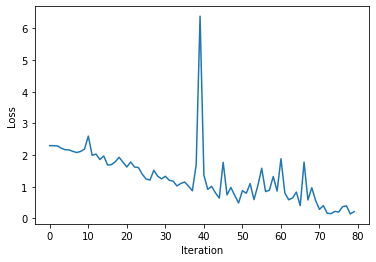

In [17]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()